# Enhanced TACO Object Detection with Detectron2

**Project Title**: Promoting Clean Environment with Smart Waste Identification by Enhancing the TACO: Trash Annotations in Context for Litter Detection Model

***ICS-504 Term 251 Project:***

**Student Names**: Ammar Alsafwani | g201183690, Abdullah Alshammasi | g202415500,  and Jafar Abu Qurayn | g201687520
**Superviosr**: Dr. Muzammil Behzad  
**University**: King Fahd University of Petroleum and Minerals


## Setup Environment

In [ ]:
# Install dependencies
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q albumentations pycocotools scikit-learn

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.2 MB/s eta 0:00:00
PyTorch: 2.8.0+cu126
CUDA Available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os

# Define paths
DATASET_PATH = '/content/drive/MyDrive/DLP/TACO'
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, 'annotations.json')
IMAGES_DIR = os.path.join(DATASET_PATH, 'data')
OUTPUT_DIR = '/content/drive/MyDrive/DLP/TACO/taco_output'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify paths
print(f"Dataset root exists: {os.path.exists(DATASET_PATH)}")
print(f"Annotations file exists: {os.path.exists(ANNOTATIONS_FILE)}")
print(f"Images directory exists: {os.path.exists(IMAGES_DIR)}")

# List batch folders
if os.path.exists(IMAGES_DIR):
    batches = sorted([d for d in os.listdir(IMAGES_DIR) if d.startswith('batch_')])
    print(f"\\nFound {len(batches)} batch folders: {batches}")

Mounted at /content/drive
Dataset root exists: True
Annotations file exists: True
Images directory exists: True
\nFound 15 batch folders: ['batch_1', 'batch_10', 'batch_11', 'batch_12', 'batch_13', 'batch_14', 'batch_15', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6', 'batch_7', 'batch_8', 'batch_9']


## Data Preparation with Proper Splits

In [ ]:
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
import copy

# Load annotations
with open(os.path.join(DATASET_PATH, 'annotations.json'), 'r') as f:
    dataset = json.load(f)

print(f"Total images: {len(dataset['images'])}")
print(f"Total annotations: {len(dataset['annotations'])}")
print(f"Total categories: {len(dataset['categories'])}")

# CLASS MAPPING
# Reduce 60 classes → 4 classes to handle imbalance
CLASS_MAP = {
    'Clear plastic bottle': 'Bottle',
    'Glass bottle': 'Bottle',
    'Other plastic bottle': 'Bottle',
    'Drink can': 'Can',
    'Food Can': 'Can',
    'Aerosol': 'Can',
    'Garbage bag': 'Plastic bag',
    'Single-use carrier bag': 'Plastic bag',
    'Polypropylene bag': 'Plastic bag',
    'Plastic film': 'Plastic bag',
    'Crisp packet': 'Plastic bag',
    'Other plastic wrapper': 'Plastic bag',
    'Six pack rings': 'Plastic bag',
    'Plastic bottle cap': 'Other litter',
    'Metal bottle cap': 'Other litter',
    'Plastic lid': 'Other litter',
    'Disposable plastic cup': 'Other litter',
    'Cigarette': 'Other litter',
}

# Map all other categories to 'Other litter' or 'Background'
def apply_class_mapping(dataset_dict, class_map):
    """Apply class mapping and remove background classes"""
    mapped_dataset = copy.deepcopy(dataset_dict)

    # Create new categories
    target_classes = sorted(list(set(class_map.values())))
    new_categories = []
    class_name_to_id = {}

    for idx, class_name in enumerate(target_classes, start=1):
        new_categories.append({
            'id': idx,
            'name': class_name,
            'supercategory': 'litter'
        })
        class_name_to_id[class_name] = idx

    # Create old_id to new_id mapping
    old_to_new = {}
    for old_cat in dataset_dict['categories']:
        old_name = old_cat['name']
        if old_name in class_map:
            new_name = class_map[old_name]
            old_to_new[old_cat['id']] = class_name_to_id[new_name]

    # Update annotations
    new_annotations = []
    valid_image_ids = set()

    for ann in mapped_dataset['annotations']:
        if ann['category_id'] in old_to_new:
            ann['category_id'] = old_to_new[ann['category_id']]
            new_annotations.append(ann)
            valid_image_ids.add(ann['image_id'])

    # Keep only images with valid annotations
    new_images = [img for img in mapped_dataset['images'] if img['id'] in valid_image_ids]

    mapped_dataset['categories'] = new_categories
    mapped_dataset['annotations'] = new_annotations
    mapped_dataset['images'] = new_images

    return mapped_dataset

# Apply mapping
dataset = apply_class_mapping(dataset, CLASS_MAP)

print(f"\nAfter class mapping:")
print(f"Images with annotations: {len(dataset['images'])}")
print(f"Annotations: {len(dataset['annotations'])}")
print(f"Classes: {len(dataset['categories'])}")
for cat in dataset['categories']:
    print(f"  - {cat['name']} (id={cat['id']})")

Total images: 1500
Total annotations: 4784
Total categories: 60

After class mapping:
Images with annotations: 1140
Annotations: 2699
Classes: 4
  - Bottle (id=1)
  - Can (id=2)
  - Other litter (id=3)
  - Plastic bag (id=4)


In [ ]:
# CREATE PROPER TRAIN/VAL/TEST SPLITS (60/20/20)

from sklearn.model_selection import train_test_split

# Get image IDs and their primary class for stratification
image_ids = [img['id'] for img in dataset['images']]
image_to_classes = defaultdict(set)

for ann in dataset['annotations']:
    image_to_classes[ann['image_id']].add(ann['category_id'])

# Use primary class (most frequent) for stratification
image_classes = []
for img_id in image_ids:
    classes = list(image_to_classes[img_id])
    primary_class = classes[0] if classes else 0
    image_classes.append(primary_class)

# Split: 60% train, 20% val, 20% test
train_ids, temp_ids, train_classes, temp_classes = train_test_split(
    image_ids, image_classes, test_size=0.4, stratify=image_classes, random_state=42
)

val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, stratify=temp_classes, random_state=42
)

print(f"\nData splits:")
print(f"Train: {len(train_ids)} images ({len(train_ids)/len(image_ids)*100:.1f}%)")
print(f"Val: {len(val_ids)} images ({len(val_ids)/len(image_ids)*100:.1f}%)")
print(f"Test: {len(test_ids)} images ({len(test_ids)/len(image_ids)*100:.1f}%)")

# Create split datasets
def create_split_dataset(full_dataset, split_ids):
    split_data = copy.deepcopy(full_dataset)
    split_data['images'] = [img for img in full_dataset['images'] if img['id'] in split_ids]
    split_data['annotations'] = [ann for ann in full_dataset['annotations'] if ann['image_id'] in split_ids]
    return split_data

train_dataset = create_split_dataset(dataset, set(train_ids))
val_dataset = create_split_dataset(dataset, set(val_ids))
test_dataset = create_split_dataset(dataset, set(test_ids))

# Save splits
with open(os.path.join(OUTPUT_DIR, 'train.json'), 'w') as f:
    json.dump(train_dataset, f)
with open(os.path.join(OUTPUT_DIR, 'val.json'), 'w') as f:
    json.dump(val_dataset, f)
with open(os.path.join(OUTPUT_DIR, 'test.json'), 'w') as f:
    json.dump(test_dataset, f)

print("\n✓ Splits saved!")


Data splits:
Train: 684 images (60.0%)
Val: 228 images (20.0%)
Test: 228 images (20.0%)

✓ Splits saved!


## Register Datasets with Detectron2

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# Unregister datasets if they already exist to prevent AssertionError
for split in ['train', 'val', 'test']:
    dataset_name = f"taco_{split}"
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)

# Register datasets
for split in ['train', 'val', 'test']:
    register_coco_instances(
        f"taco_{split}",
        {},
        os.path.join(OUTPUT_DIR, f"{split}.json"),
        IMAGES_DIR # Ensure IMAGES_DIR is used
    )

# Set class names
class_names = [cat['name'] for cat in dataset['categories']]
for split in ['train', 'val', 'test']:
    MetadataCatalog.get(f"taco_{split}").thing_classes = class_names

print(f"Registered datasets with {len(class_names)} classes:")
print(class_names)

Registered datasets with 4 classes:
['Bottle', 'Can', 'Other litter', 'Plastic bag']


## Configure Training

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

# KEY IMPROVEMENT: Use COCO pre-trained weights as starting point!
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Dataset
cfg.DATASETS.TRAIN = ("taco_train",)
cfg.DATASETS.TEST = ("taco_val",)  # Validate during training
cfg.DATALOADER.NUM_WORKERS = 2

# Model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # Faster training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Training schedule
cfg.SOLVER.IMS_PER_BATCH = 4  # Adjust based on GPU memory
cfg.SOLVER.BASE_LR = 0.001  # Good starting LR with transfer learning
cfg.SOLVER.MAX_ITER = 3000  # ~30-40 epochs for 1200 training images
cfg.SOLVER.STEPS = (2000, 2700)  # LR decay steps
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 200
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.WEIGHT_DECAY = 0.0001

# Evaluation
cfg.TEST.EVAL_PERIOD = 500  # Evaluate every 500 iterations

# Multi-scale training - helps with small objects
cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)  # Multi-scale
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333

# Data augmentation
cfg.INPUT.RANDOM_FLIP = "horizontal"

# Output
cfg.OUTPUT_DIR = os.path.join(OUTPUT_DIR, "model_output")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Base LR: {cfg.SOLVER.BASE_LR}")
print(f"  Max iterations: {cfg.SOLVER.MAX_ITER}")
print(f"  Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"  Eval period: {cfg.TEST.EVAL_PERIOD}")
print(f"  Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")

Configuration:
  Base LR: 0.001
  Max iterations: 3000
  Batch size: 4
  Eval period: 500
  Number of classes: 4


## Train Model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class TACOTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

# Train
trainer = TACOTrainer(cfg)
trainer.resume_or_load(resume=False)

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Training on {len(train_ids)} images")
print(f"Validating on {len(val_ids)} images")
print("="*80 + "\n")

trainer.train()

[11/14 17:13:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}



STARTING TRAINING
Training on 684 images
Validating on 228 images

[11/14 17:13:30 d2.engine.train_loop]: Starting training from iteration 0
[11/14 17:13:46 d2.utils.events]:  eta: 0:31:09  iter: 19  total_loss: 2.885  loss_cls: 1.379  loss_box_reg: 0.1127  loss_mask: 0.689  loss_rpn_cls: 0.5104  loss_rpn_loc: 0.08337    time: 0.7748  last_time: 1.5703  data_time: 0.5982  last_data_time: 1.3488   lr: 9.5905e-05  max_mem: 4789M
[11/14 17:14:36 d2.utils.events]:  eta: 1:03:01  iter: 39  total_loss: 1.213  loss_cls: 0.255  loss_box_reg: 0.1216  loss_mask: 0.65  loss_rpn_cls: 0.05894  loss_rpn_loc: 0.02068    time: 1.6946  last_time: 2.3349  data_time: 2.3261  last_data_time: 2.1234   lr: 0.00019581  max_mem: 4789M
[11/14 17:15:24 d2.utils.events]:  eta: 1:27:05  iter: 59  total_loss: 0.8958  loss_cls: 0.1279  loss_box_reg: 0.09152  loss_mask: 0.5522  loss_rpn_cls: 0.0647  loss_rpn_loc: 0.02417    time: 1.9274  last_time: 2.0376  data_time: 2.1777  last_data_time: 1.8383   lr: 0.00029571 

## Evaluate on Test Set

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load best model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

# Evaluate on test set
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

evaluator = COCOEvaluator("taco_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
test_loader = build_detection_test_loader(cfg, "taco_test")
results = inference_on_dataset(predictor.model, test_loader, evaluator)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"BBox mAP@0.5:0.95: {results['bbox']['AP']:.2f}%")
print(f"BBox mAP@0.5: {results['bbox']['AP50']:.2f}%")
print(f"Segm mAP@0.5:0.95: {results['segm']['AP']:.2f}%")
print(f"Segm mAP@0.5: {results['segm']['AP50']:.2f}%")
print("="*80)

# Save results
with open(os.path.join(cfg.OUTPUT_DIR, 'final_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to {cfg.OUTPUT_DIR}/final_results.json")

[11/14 18:02:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLP/TACO/taco_output/model_output/model_final.pth ...

FINAL EVALUATION ON TEST SET
WARNING [11/14 18:02:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/14 18:02:13 d2.data.datasets.coco]: Loaded 228 images in COCO format from /content/drive/MyDrive/DLP/TACO/taco_output/test.json
[11/14 18:02:13 d2.data.build]: Distribution of instances among all 4 categories:
|  category   | #instances   |  category  | #instances   |   category   | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
|   Bottle    | 81           |    Can     | 45           | Other litter | 252          |
| Plastic bag | 147          |            |              |              |              |
|    total    | 525          |            |              |     

## Visualize Predictions

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
import cv2
import matplotlib.pyplot as plt
import random

# Visualize random test images
test_metadata = MetadataCatalog.get("taco_test")
test_dicts = DatasetCatalog.get("taco_test")

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

for idx in range(6):
    d = random.choice(test_dicts)
    img = cv2.imread(d["file_name"])

    # Predict
    outputs = predictor(img)

    # Visualize
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW)

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    axes[idx].imshow(out.get_image())
    axes[idx].axis('off')
    axes[idx].set_title(f"Image {d['image_id']}: {len(outputs['instances'])} detections")

plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Predictions saved to {cfg.OUTPUT_DIR}/predictions.png")

Output hidden; open in https://colab.research.google.com to view.

[11/14 18:39:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DLP/TACO/taco_output/model_output/model_final.pth ...


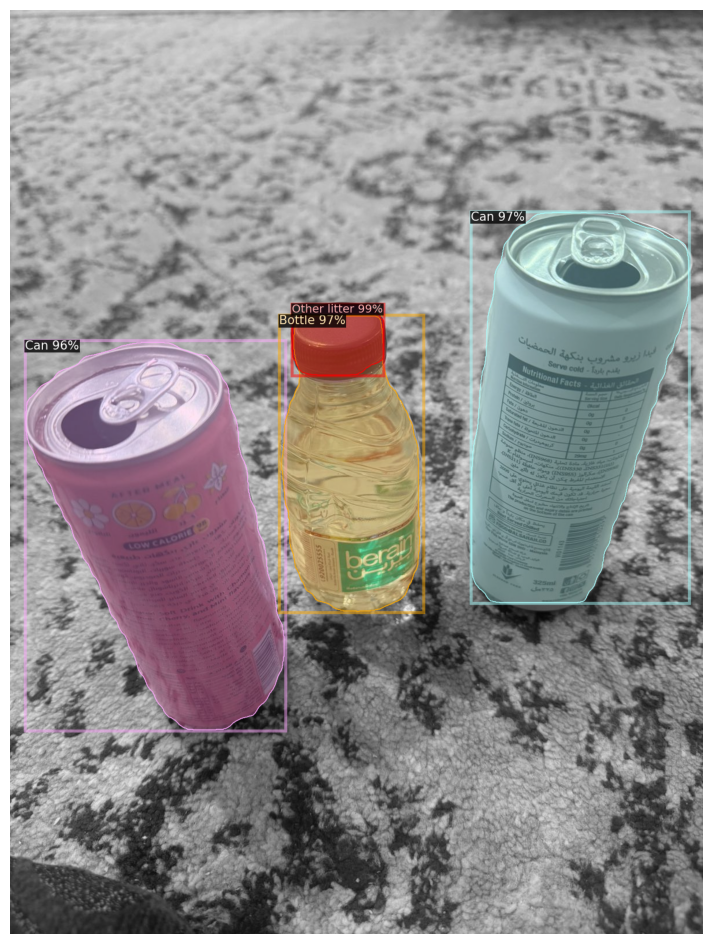

✓ Prediction saved to: /content/drive/MyDrive/DLP/TACO/taco_output/single_prediction.jpg


In [ ]:
# =============================
# TEST A SINGLE IMAGE
# =============================

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Path to the trained model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/DLP/TACO/taco_output/model_output/model_final.pth"  # <-- Change if needed
predictor = DefaultPredictor(cfg)

# -------------------------------------
# 1️⃣ Choose an image from your Drive
# -------------------------------------
test_image_path = "/content/WhatsApp Image 2025-11-14 at 9.38.22 PM.jpeg"  # <-- CHANGE THIS

# Load image
image = cv2.imread(test_image_path)
image_rgb = image[:, :, ::1]

# -------------------------------------
# 2️⃣ Run prediction
# -------------------------------------
outputs = predictor(image)

# -------------------------------------
# 3️⃣ Visualize results
# -------------------------------------
v = Visualizer(image_rgb[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.0,
               instance_mode=ColorMode.IMAGE_BW)

result = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12, 12))
plt.imshow(result.get_image())
plt.axis("off")
plt.show()

# -------------------------------------
# 4️⃣ Save output image
# -------------------------------------
out_path = "/content/drive/MyDrive/DLP/TACO/taco_output/single_prediction.jpg"
cv2.imwrite(out_path, result.get_image()[:, :, ::-1])

print(f"✓ Prediction saved to: {out_path}")
